In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from glob import glob
import os
import shutil
import time, datetime

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [2]:
def read_log_file(logpath):
    res = {}
    for log in glob(logpath):
        with open(log, 'r') as f:
            for line in f:
                if bool(re.search(r'(?:epoch|checkpoint) [0-9]+', line)):
                    split = re.search(r'(?:epoch|checkpoint) [0-9]+ - ([A-Za-z]+)', line).groups()[0]
                    if split not in res:
                        res[split] = defaultdict(list)
                        
                    stime = re.search(r'^\[(.*?)\]', line).groups()[0]
                    timestamp = datetime.datetime.strptime(stime, "%Y/%m/%d-%H:%M:%S").timestamp()
                    
                    n_sequences = re.search(r'sequences: ([0-9]+)', line).groups()[0]
                    
                    metrics = re.search(r'(?:epoch|checkpoint).*(loss.*)', line).groups()[0].split(',')
                    metrics = [x.strip().split(':') for x in metrics]
                    
                    checkpoint = re.search(r'checkpoint ([0-9]+)', line)
                    epoch = re.search(r'epoch:? ([0-9]+)', line)
                    if epoch:
                        epoch = int(epoch.groups()[0])
                    if checkpoint:
                        checkpoint = int(checkpoint.groups()[0])
                        
                    for metric, metric_value in metrics:
                        if not '=' in metric_value:
                            metric_value = float(metric_value)
                        res[split][metric].append((timestamp,int(n_sequences),epoch,checkpoint,metric_value))
    return res


In [3]:
data_dir='/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/'

res = {}

models = ('dnabert-3utr-2e','dnabert2-3utr-2e','ntrans-v2-100m-3utr-2e',
              'stspace-3utr-2e','stspace-spaw-3utr-2e','dnabert2-z','stspace-3utr-DNA',
              'stspace-spaw-3utr-DNA','stspace-3utr-hs')

for model in models:
#stspace-spaw-3utr-DNA
    if model!='dnabert2-z':
        model_dir = 'zoonomia-3utr'
    else:
        model_dir = 'zoonomia'
    res[model] = read_log_file(data_dir + model_dir + '/' + model + '/log*')

In [4]:
def get_metric_change_last_n(epochs,metric_epochs,n_epochs_st=5,threshold_pct=1):
    '''
    get the relative metric change for the last n_epochs_st epochs
    find the threshold_epoch where the change first drops below threshold_pct
    epochs: monotonic array with epoch numbers
    metric_epochs: array with 1 metric value per epoch
    '''
    metric_increase_all = []
    threshold_epoch = None
    for i in range(n_epochs_st,len(metric_epochs)):
        metric_increase_pct = abs(metric_epochs[i]-metric_epochs[i-n_epochs_st])/metric_epochs[i-n_epochs_st]*100
        metric_increase_all.append((epochs[i],metric_increase_pct))
        if metric_increase_all[-1][1]<threshold_pct and threshold_epoch is None:
            print(f'epoch {epochs[i]}: metric change for the last {n_epochs_st} epochs is below {threshold_pct}%')
            threshold_epoch = epochs[i]
    if not metric_increase_all:
        metric_increase_all.append((epochs[-1],np.nan))
    return metric_increase_all, threshold_epoch

In [5]:
models = {
          'dnabert-3utr-2e': 'DNABERT-3UTR', 
          'dnabert2-3utr-2e': 'DNABERT2-3UTR',
          'ntrans-v2-100m-3utr-2e': 'NTv2-100M-3UTR',          
          'stspace-3utr-2e': 'StateSpace', 
          'stspace-spaw-3utr-2e': 'StateSpace-SA',
          'stspace-spaw-3utr-DNA': 'StateSpace-SA-DNA',
          'stspace-3utr-DNA': 'StateSpace-DNA',
          'dnabert2-z': 'DNABERT2-ZOO',
          'stspace-3utr-hs': 'StateSpace-HS',
         }

In [6]:
def get_available_checkpoint(model,threshold_checkpoint):
    '''
    get first available checkpoint after threshold_checkpoint
    '''
    if model!='dnabert2-z':
        model_dir = 'zoonomia-3utr'
    else:
        model_dir = 'zoonomia'
    checkpoint_dirs = glob(data_dir + model_dir + '/' + model + '/checkpoints/*')
    chkpts,checkpoint_dirs = zip(*sorted(zip([int(checkpoint_dir.split('_')[-1]) for checkpoint_dir in checkpoint_dirs],checkpoint_dirs)))
    chkpt_idx = np.argmax(np.array(chkpts)>=threshold_checkpoint)
    return  checkpoint_dirs[chkpt_idx]

In [7]:
def get_training_time(timestamps,n_sequences,epochs):
    timestamps = np.array(timestamps)
    n_sequences = np.array(n_sequences)
    delta_sequences = np.diff(n_sequences)
    delta_timestamps = np.diff(timestamps)
    seq_per_sec = np.median(delta_sequences/delta_timestamps)
    seq_per_epoch = np.median(np.diff(n_sequences[1:][np.diff(epochs)>0]))
    training_time_per_epoch = seq_per_epoch/seq_per_sec
    return training_time_per_epoch

Average training time on 10GPUs: 158 min/epoch
Average training time on 2GPUs: 781 min/epoch
dnabert-3utr-2e
epoch 6: metric change for the last 3 epochs is below 1%
checkpoint dir: /lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/checkpoints/chkpt_40
Last epoch:17,loss change in last 3 epochs: 0.5%

Average training time on 10GPUs: 39 min/epoch
Average training time on 2GPUs: 180 min/epoch
dnabert2-3utr-2e
epoch 29: metric change for the last 3 epochs is below 1%
checkpoint dir: /lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert2-3utr-2e/checkpoints/chkpt_275
Last epoch:47,loss change in last 3 epochs: 0.9%

Average training time on 2GPUs: 1677 min/epoch
ntrans-v2-100m-3utr-2e
epoch 23: metric change for the last 3 epochs is below 1%
checkpoint dir: /lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/ntrans-v2-100m-3utr-2e/checkpoints/chkpt_633
Last epoch:23,loss change in last 3 epo

/home/icb/sergey.vilov/miniconda3/envs/ntrans/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/sergey.vilov/miniconda3/envs/ntrans/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


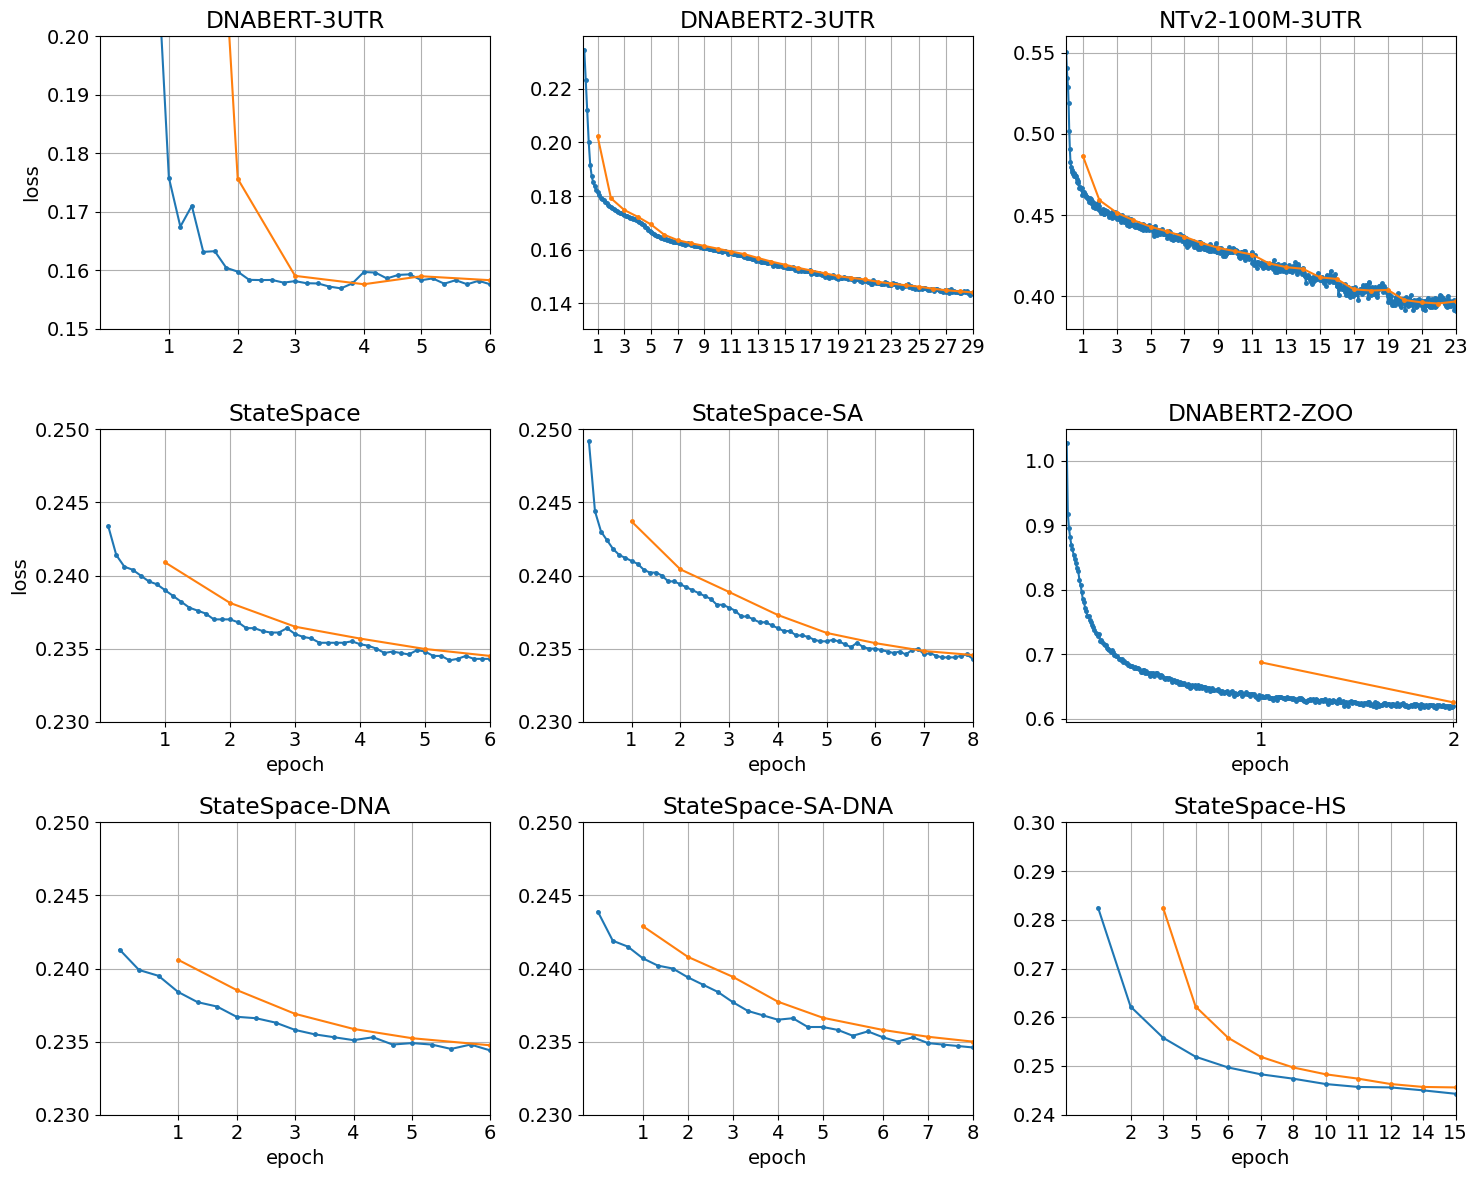

In [11]:
n_epochs_st = 3

metric_name = 'loss' 
#metric_name = 'masked acc'

checkpoint_dir = {}

fig, axes = plt.subplots(3,3, figsize=(15,12))

axes = axes.flatten()

ax_idx = 0

for model,ax in zip(res.keys(),axes):
    
    timestamps, n_sequences, epochs, checkpoints, metric_checkpoints = zip(*sorted(res[model]['train'][metric_name],key=lambda x:x[0]))
    #metric = np.array(res[model]['train']['loss'])
    
    checkpoints = np.array(checkpoints)
    epochs = np.array(epochs)
    metric_checkpoints = np.array(metric_checkpoints)

    loss_break_idx = 0
    
    if metric_name=='loss' and model in ('dnabert-3utr-2e','dnabert2-3utr-2e','ntrans-v2-250m-3utr-2e','stspace-3utr-2e','stspace-spaw-3utr-2e'):
        loss_break_idx = np.argmin(np.diff(metric_checkpoints))+1 #loss break due to changing from 10 to 2 GPUs
        metric_checkpoints[:loss_break_idx]=metric_checkpoints[:loss_break_idx]/5 #correct for loss break        

        if model!='ntrans-v2-250m-3utr-2e':
            av_t_10gpu = get_training_time(timestamps[:loss_break_idx],n_sequences[:loss_break_idx],epochs[:loss_break_idx])
            print(f'Average training time on 10GPUs: {int(av_t_10gpu//60)} min/epoch')

    av_t_2gpu = get_training_time(timestamps[loss_break_idx:],n_sequences[loss_break_idx:],epochs[loss_break_idx:])
    print(f'Average training time on 2GPUs: {int(av_t_2gpu//60)} min/epoch')

    major_ticks = checkpoints[1:][np.diff(epochs)>0] #where epoch changes
    tick_labels = epochs[1:][np.diff(epochs)>0] #where epoch changes
    
    #metric_epochs = metric_checkpoints[1:][np.diff(epochs)>0] #where epoch changes
    
    ax.plot(checkpoints,metric_checkpoints,marker='.',markersize=5, label=model)

    epoch_ends = np.where(np.diff(epochs)>0)[0]
    epoch_starts = np.insert(epoch_ends,0,0)
    metric_epochs = [np.mean(metric_checkpoints[start:end]) for start,end in zip(epoch_starts,epoch_ends)]
    
    ax.plot(major_ticks,metric_epochs,marker='.',markersize=5, label=model)
    
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(tick_labels)

    
    if 'stspace' in model:
        #stop at the 15th epoch
        #ax.set_xlim([0,checkpoints[epochs==15].min()])
        if '-hs' in model:
            ax.set_ylim([0.24,0.3])
        else:
            ax.set_ylim([0.23,0.25])
        
        
    if 'dnabert-' in model:
        #skip the start of the plot, to see the tail better
        if metric_name == 'masked acc':
            ax.set_ylim([0.4,0.5])
        elif metric_name == 'loss':
            ax.set_ylim([0.15,0.2])
            
    if model in ('ntrans-v2-100m-3utr-2e','dnabert2-3utr-2e'):
        #take every 3rd epoch to improve visualization
        ax.set_xticks(major_ticks[::2])

    if 'v2-100m' in model:
        ax.set_ylim([0.38,0.56])

    #if 'v2-250m' in model:
        #take every 3rd epoch to improve visualization
    #    ax.set_ylim([0.1,0.2])
        
    #ax.plot((train_loss-min(train_loss))/(max(train_loss)-min(train_loss)),marker='.',markersize=5, label=model)
#ax.set_ylim([0.7,1])
    
    ax.grid(True)
    ax.set_title(models[model])

    if ax_idx in (0,3):
        ax.set_ylabel('loss')

    if ax_idx>2:
        ax.set_xlabel('epoch')

    print(model)
    
    metric_change_pct, threshold_epoch = get_metric_change_last_n(tick_labels,metric_epochs,n_epochs_st=n_epochs_st)
    if threshold_epoch:
        threshold_checkpoint = checkpoints[epochs==threshold_epoch].min()
        checkpoint_dir[model] = get_available_checkpoint(model,threshold_checkpoint)
    else:
        checkpoint_dir[model] = get_available_checkpoint(model,checkpoints.max())
    print(f'checkpoint dir: {checkpoint_dir[model]}')
    #print(model,f'last epoch: {metric_change_pct[-1][0]}, last {metric_name}: {metric_epochs[-1]:.2}')
    print(f'Last epoch:{epochs[-1]},{metric_name} change in last {n_epochs_st} epochs: {metric_change_pct[-1][1]:.1f}%')

    if threshold_epoch:
        ax.set_xlim([0,threshold_checkpoint])

    if 'dnabert2-z' in model:
        ax.set_xlim([0,checkpoints[epochs==1].min()*2])

    ax_idx+=1

    #if ax_idx == len(axes):
    #    ax.set_visible(False)

    print()

fig.tight_layout()

In [33]:
def remove_redundant_checkpoints(model,checkpoints_at_epoch_change):
    '''
    Leave only one checkpoint per epoch
    '''
    if model!='dnabert2-z':
        model_dir = 'zoonomia-3utr'
    else:
        model_dir = 'zoonomia'
    checkpoint_dirs = glob(data_dir + model_dir + '/' + model + '/checkpoints/*')
    chkpts,checkpoint_dirs = zip(*sorted(zip([int(checkpoint_dir.split('_')[-1]) for checkpoint_dir in checkpoint_dirs],checkpoint_dirs)))
    
    #chkpt_idx_to_keep = [np.argmax(np.array(chkpts)>=threshold_checkpoint) for threshold_checkpoint in checkpoints_at_epoch_change]
    
    #checkpoint_dirs_to_remove = [checkpoint_dir for idx,checkpoint_dir in enumerate(checkpoint_dirs) if not idx in chkpt_idx_to_keep]
    #checkpoint_dirs_to_keep = [checkpoint_dir for idx,checkpoint_dir in enumerate(checkpoint_dirs) if  idx in chkpt_idx_to_keep]
    checkpoint_dirs_to_keep = [checkpoint_dir[model]]
    checkpoint_dirs_to_remove = [x for x in checkpoint_dirs if x!=checkpoint_dir[model]]
    
    return checkpoint_dirs_to_remove,checkpoint_dirs_to_keep

In [38]:
for model in checkpoint_dir.keys():
    print(model)
    timestamps, n_sequences, epochs, checkpoints, metric_checkpoints = zip(*sorted(res[model]['train'][metric_name],key=lambda x:x[1]))
    checkpoints = np.array(checkpoints)
    epochs = np.array(epochs)
    checkpoints_at_epoch_change = checkpoints[[i for i in range(1,len(epochs)) if epochs[i]!=epochs[i-1]]]
    checkpoint_dirs_to_remove,checkpoint_dirs_to_keep = remove_redundant_checkpoints(model,checkpoints_at_epoch_change)
    c = np.array([int(x.split('_')[1]) for x in checkpoint_dirs_to_keep])
    print('Keeping checkpoints:')
    print(list(zip(['epoch_'+str(epochs[np.argmax(checkpoints==i)]) for i in c],[f'chkpt_{i}' for i in c]))) 
    assert len(checkpoints_at_epoch_change) == epochs[-1]
    assert checkpoint_dir[model] not in checkpoint_dirs_to_remove
    print('Following checkpoint dirs will be removed:')
    for i in checkpoint_dirs_to_remove:
        assert i.startswith('/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models')
        print(i)
        #shutil.rmtree(i)
    print()


dnabert-3utr-2e
Keeping checkpoints:
[('epoch_7', 'chkpt_40')]
Following checkpoint dirs will be removed:
/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/checkpoints/chkpt_8
/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/checkpoints/chkpt_16
/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/checkpoints/chkpt_24
/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/checkpoints/chkpt_32
/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/checkpoints/chkpt_48
/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/checkpoints/chkpt_56
/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/checkpoints/chkpt_64
/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/zoonomia-3utr/dnabert-3utr-2e/chec

In [ ]:
import datetime
import re

#dnabert-2
t1 = '[2024/11/20-09:14:36]'
t2 = '[2024/11/20-09:22:12]'

#dnabert
#t1 = '[2024/11/19-17:39:49]'
#t2 = '[2024/11/19-17:42:30]'

#ntrans-100m
t1 = '[2024/11/19-17:39:49]'
t2 = '[2024/11/19-17:49:33]'

nseq=18134

stime1= re.search(r'^\[(.*?)\]', t1).groups()[0]
stime2= re.search(r'^\[(.*?)\]', t2).groups()[0]

timestamp1 = datetime.datetime.strptime(stime1, "%Y/%m/%d-%H:%M:%S").timestamp()
timestamp2 = datetime.datetime.strptime(stime2, "%Y/%m/%d-%H:%M:%S").timestamp()

(timestamp2-timestamp1)/nseq